### Generate plots

### Input
* Before running this notebook you have to generate the input dataframe, **evaluation_all.tsv**, with the main.py script.
* Optionally, a mapping file specifying group and label of methods can be used to select only one method (the best) for each group and each namespace.

#### Output
* 3 figures, *fig_<metric>_<namespace>.png*
* 1 TSV, *fig_<metric>.tsv*

In [122]:
# Input
# df_file = "../../CAFA-evaluator_data/CAFA3_inga/results/evaluation_all.tsv"
# out_folder = "../../CAFA-evaluator_data/CAFA3_inga/results"

# df_file = "../../CAFA-evaluator_data/test_propagation/evaluation_all.tsv"
# out_folder = "../../CAFA-evaluator_data/test_propagation"

df_file = "../../CAFA-evaluator_data/pkg_example/results/evaluation_all.tsv"
out_folder = "../../CAFA-evaluator_data/pkg_example/results"

# Set to None if you don't want to use it. Results will not be grouped/filtered by team
names_file = None
# names_file = "../../CAFA-evaluator_data/CAFA3/names.tsv"

# Cumulate the last column of the cols variable, e.g. "pr" --> precision, so that the curves are monotonic as in CAFA
cumulate = True

# Select a metric
metric, cols = ('f', ['rc', 'pr'])
# metric, cols =  ('wf', ['wrc', 'wpr'])
# metric, cols = ('s', ['ru', 'mi'])

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.set_loglevel("info")

In [124]:
df = pd.read_csv(df_file, sep="\t")
df

,filename,ns,tau,cov,pr,rc,f
0,pred_5.tsv,disorder_function,0.01,1.00000,0.21402,0.94077,0.34871
1,pred_5.tsv,disorder_function,0.02,1.00000,0.21402,0.94077,0.34871
2,pred_5.tsv,disorder_function,0.03,1.00000,0.21415,0.94077,0.34889
3,pred_5.tsv,disorder_function,0.04,1.00000,0.21415,0.94077,0.34889
4,pred_5.tsv,disorder_function,0.05,1.00000,0.21415,0.94077,0.34889
...,...,...,...,...,...,...,...
347,pred_1.tsv,disorder_function,0.41,0.00595,0.00000,0.00000,0.00000
348,pred_1.tsv,disorder_function,0.42,0.00595,0.00000,0.00000,0.00000
349,pred_1.tsv,disorder_function,0.43,0.00595,0.00000,0.00000,0.00000
350,pred_1.tsv,disorder_function,0.44,0.00595,0.00000,0.00000,0.00000


In [125]:
if names_file is None:
    df['group'] = df['filename']
    df['label'] = df['filename']
    df['is_baseline'] = False
else:
    # Set method information (optional)
    methods = pd.read_csv(names_file, delim_whitespace=True)
    df = pd.merge(df, methods, on='filename', how='left')
    df['group'].fillna(df['filename'], inplace=True)
    df['label'].fillna(df['filename'], inplace=True)
    if 'is_baseline' not in df:
        df['is_baseline'] = False
    else:
        df['is_baseline'].fillna(False, inplace=True)
df = df.drop(columns='filename').set_index(['group', 'label', 'ns', 'tau'])
df

cov       pr       rc  \
group      label      ns                tau                               
pred_5.tsv pred_5.tsv disorder_function 0.01  1.00000  0.21402  0.94077   
                                        0.02  1.00000  0.21402  0.94077   
                                        0.03  1.00000  0.21415  0.94077   
                                        0.04  1.00000  0.21415  0.94077   
                                        0.05  1.00000  0.21415  0.94077   
...                                               ...      ...      ...   
pred_1.tsv pred_1.tsv disorder_function 0.41  0.00595  0.00000  0.00000   
                                        0.42  0.00595  0.00000  0.00000   
                                        0.43  0.00595  0.00000  0.00000   
                                        0.44  0.00595  0.00000  0.00000   
                                        0.45  0.00595  0.00000  0.00000   

                                                    f  is_baseline  
group      label      ns                tau                         
pred_5.tsv pred_5.tsv disorder_function 0.01  0.34871        False  
                                        0.02  0.34871        False  
                                        0.03  0.34889        False  
                                        0.04  0.34889        False  
                                        0.05  0.34889        False  
...                                               ...          ...  
pred_1.tsv pred_1.tsv disorder_function 0.41  0.00000        False  
                                        0.42  0.00000        False  
                                        0.43  0.00000        False  
                                        0.44  0.00000        False  
                                        0.45  0.00000        False  

[352 rows x 5 columns]

In [126]:
# Assign colors based on group
cmap = plt.get_cmap('tab20')
df['colors'] = df.index.get_level_values('group')
df['colors'] = pd.factorize(df['colors'])[0]
df['colors'] = df['colors'].apply(lambda x: cmap.colors[x % len(cmap.colors)])
df

cov       pr       rc  \
group      label      ns                tau                               
pred_5.tsv pred_5.tsv disorder_function 0.01  1.00000  0.21402  0.94077   
                                        0.02  1.00000  0.21402  0.94077   
                                        0.03  1.00000  0.21415  0.94077   
                                        0.04  1.00000  0.21415  0.94077   
                                        0.05  1.00000  0.21415  0.94077   
...                                               ...      ...      ...   
pred_1.tsv pred_1.tsv disorder_function 0.41  0.00595  0.00000  0.00000   
                                        0.42  0.00595  0.00000  0.00000   
                                        0.43  0.00595  0.00000  0.00000   
                                        0.44  0.00595  0.00000  0.00000   
                                        0.45  0.00595  0.00000  0.00000   

                                                    f  is_baseline  \
group      label      ns                tau                          
pred_5.tsv pred_5.tsv disorder_function 0.01  0.34871        False   
                                        0.02  0.34871        False   
                                        0.03  0.34889        False   
                                        0.04  0.34889        False   
                                        0.05  0.34889        False   
...                                               ...          ...   
pred_1.tsv pred_1.tsv disorder_function 0.41  0.00000        False   
                                        0.42  0.00000        False   
                                        0.43  0.00000        False   
                                        0.44  0.00000        False   
                                        0.45  0.00000        False   

                                                                                         colors  
group      label      ns                tau                                                      
pred_5.tsv pred_5.tsv disorder_function 0.01  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                        0.02  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                        0.03  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                        0.04  (0.12156862745098039, 0.4666666666666667, 0.70...  
                                        0.05  (0.12156862745098039, 0.4666666666666667, 0.70...  
...                                                                                         ...  
pred_1.tsv pred_1.tsv disorder_function 0.41  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                        0.42  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                        0.43  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                        0.44  (0.17254901960784313, 0.6274509803921569, 0.17...  
                                        0.45  (0.17254901960784313, 0.6274509803921569, 0.17...  

[352 rows x 6 columns]

In [127]:
# Identify the best methods and thresholds
index_best = df.groupby(level=['group', 'ns'])[metric].idxmax() if metric in ['f', 'wf'] else df.groupby(['group', 'ns'])[metric].idxmin()
index_best

group       ns               
pred_1.tsv  disorder_function    (pred_1.tsv, pred_1.tsv, disorder_function, 0.06)
pred_2.tsv  disorder_function    (pred_2.tsv, pred_2.tsv, disorder_function, 0.84)
pred_3.tsv  disorder_function    (pred_3.tsv, pred_3.tsv, disorder_function, 0.89)
pred_4.tsv  disorder_function    (pred_4.tsv, pred_4.tsv, disorder_function, 0.06)
pred_5.tsv  disorder_function    (pred_5.tsv, pred_5.tsv, disorder_function, 0.38)
Name: f, dtype: object

In [128]:
# Filter the dataframe for the best method and threshold
df_best = df.loc[index_best, ['cov', 'colors'] + cols + [metric]]
df_best

,,,,cov,colors,rc,pr,f
group,label,ns,tau,,,,,
pred_1.tsv,pred_1.tsv,disorder_function,0.06,0.60714,"(0.17254901960784313, 0.6274509803921569, 0.17...",0.22669,0.67157,0.33896
pred_2.tsv,pred_2.tsv,disorder_function,0.84,0.97024,"(0.6823529411764706, 0.7803921568627451, 0.909...",0.38710,0.30562,0.34157
pred_3.tsv,pred_3.tsv,disorder_function,0.89,1.00000,"(1.0, 0.7333333333333333, 0.47058823529411764)",0.55704,0.49226,0.52265
pred_4.tsv,pred_4.tsv,disorder_function,0.06,1.00000,"(1.0, 0.4980392156862745, 0.054901960784313725)",0.66468,0.66667,0.66567
pred_5.tsv,pred_5.tsv,disorder_function,0.38,0.98214,"(0.12156862745098039, 0.4666666666666667, 0.70...",0.67063,0.45638,0.54314


In [129]:
# Filter the dataframe for the best methods
df_methods = df.reset_index('tau').loc[[ele[:-1] for ele in index_best], ['tau', 'cov', 'colors'] + cols + [metric]].sort_index()

# Makes the curves monotonic. Cumulative max on the last column of the cols variable, e.g. "pr" --> precision
if cumulate:
    if metric in ['f', 'wf']:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummax()
    else:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummin()

# Save to file
df_methods.drop(columns=['colors']).to_csv('{}/fig_{}.tsv'.format(out_folder, metric), float_format="%.3f", sep="\t")
df_methods

tau      cov  \
group      label      ns                                 
pred_1.tsv pred_1.tsv disorder_function  0.01  1.00000   
                      disorder_function  0.02  1.00000   
                      disorder_function  0.03  0.99405   
                      disorder_function  0.04  0.98810   
                      disorder_function  0.05  0.92262   
...                                       ...      ...   
pred_5.tsv pred_5.tsv disorder_function  0.95  0.03571   
                      disorder_function  0.96  0.03571   
                      disorder_function  0.97  0.03571   
                      disorder_function  0.98  0.03571   
                      disorder_function  0.99  0.03571   

                                                                                    colors  \
group      label      ns                                                                     
pred_1.tsv pred_1.tsv disorder_function  (0.17254901960784313, 0.6274509803921569, 0.17...   
                      disorder_function  (0.17254901960784313, 0.6274509803921569, 0.17...   
                      disorder_function  (0.17254901960784313, 0.6274509803921569, 0.17...   
                      disorder_function  (0.17254901960784313, 0.6274509803921569, 0.17...   
                      disorder_function  (0.17254901960784313, 0.6274509803921569, 0.17...   
...                                                                                    ...   
pred_5.tsv pred_5.tsv disorder_function  (0.12156862745098039, 0.4666666666666667, 0.70...   
                      disorder_function  (0.12156862745098039, 0.4666666666666667, 0.70...   
                      disorder_function  (0.12156862745098039, 0.4666666666666667, 0.70...   
                      disorder_function  (0.12156862745098039, 0.4666666666666667, 0.70...   
                      disorder_function  (0.12156862745098039, 0.4666666666666667, 0.70...   

                                              rc       pr        f  
group      label      ns                                            
pred_1.tsv pred_1.tsv disorder_function  0.39276  0.19494  0.26056  
                      disorder_function  0.39276  0.20288  0.26755  
                      disorder_function  0.38383  0.21806  0.27812  
                      disorder_function  0.38085  0.27560  0.31979  
                      disorder_function  0.36895  0.28280  0.32018  
...                                          ...      ...      ...  
pred_5.tsv pred_5.tsv disorder_function  0.01786  0.68023  0.03409  
                      disorder_function  0.01786  0.68023  0.03409  
                      disorder_function  0.01786  0.68023  0.03409  
                      disorder_function  0.01786  0.68023  0.03409  
                      disorder_function  0.01786  0.68023  0.03409  

[352 rows x 6 columns]

In [130]:
# Calculate the max coverage across all thresholds
df_best['max_cov'] = df_methods.groupby(level=['group', 'label', 'ns'])['cov'].max()
df_best

,,,,cov,colors,rc,pr,f,max_cov
group,label,ns,tau,,,,,,
pred_1.tsv,pred_1.tsv,disorder_function,0.06,0.60714,"(0.17254901960784313, 0.6274509803921569, 0.17...",0.22669,0.67157,0.33896,1.0
pred_2.tsv,pred_2.tsv,disorder_function,0.84,0.97024,"(0.6823529411764706, 0.7803921568627451, 0.909...",0.38710,0.30562,0.34157,1.0
pred_3.tsv,pred_3.tsv,disorder_function,0.89,1.00000,"(1.0, 0.7333333333333333, 0.47058823529411764)",0.55704,0.49226,0.52265,1.0
pred_4.tsv,pred_4.tsv,disorder_function,0.06,1.00000,"(1.0, 0.4980392156862745, 0.054901960784313725)",0.66468,0.66667,0.66567,1.0
pred_5.tsv,pred_5.tsv,disorder_function,0.38,0.98214,"(0.12156862745098039, 0.4666666666666667, 0.70...",0.67063,0.45638,0.54314,1.0


In [131]:
# Set a label column for the plot legend
df_best['label'] = df_best.index.get_level_values('label')
df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}={x[metric]:.3f} C={x['max_cov']:.3f})", axis=1)
df_best

,,,,cov,colors,rc,pr,f,max_cov,label
group,label,ns,tau,,,,,,,
pred_1.tsv,pred_1.tsv,disorder_function,0.06,0.60714,"(0.17254901960784313, 0.6274509803921569, 0.17...",0.22669,0.67157,0.33896,1.0,pred_1.tsv (F=0.339 C=1.000)
pred_2.tsv,pred_2.tsv,disorder_function,0.84,0.97024,"(0.6823529411764706, 0.7803921568627451, 0.909...",0.38710,0.30562,0.34157,1.0,pred_2.tsv (F=0.342 C=1.000)
pred_3.tsv,pred_3.tsv,disorder_function,0.89,1.00000,"(1.0, 0.7333333333333333, 0.47058823529411764)",0.55704,0.49226,0.52265,1.0,pred_3.tsv (F=0.523 C=1.000)
pred_4.tsv,pred_4.tsv,disorder_function,0.06,1.00000,"(1.0, 0.4980392156862745, 0.054901960784313725)",0.66468,0.66667,0.66567,1.0,pred_4.tsv (F=0.666 C=1.000)
pred_5.tsv,pred_5.tsv,disorder_function,0.38,0.98214,"(0.12156862745098039, 0.4666666666666667, 0.70...",0.67063,0.45638,0.54314,1.0,pred_5.tsv (F=0.543 C=1.000)


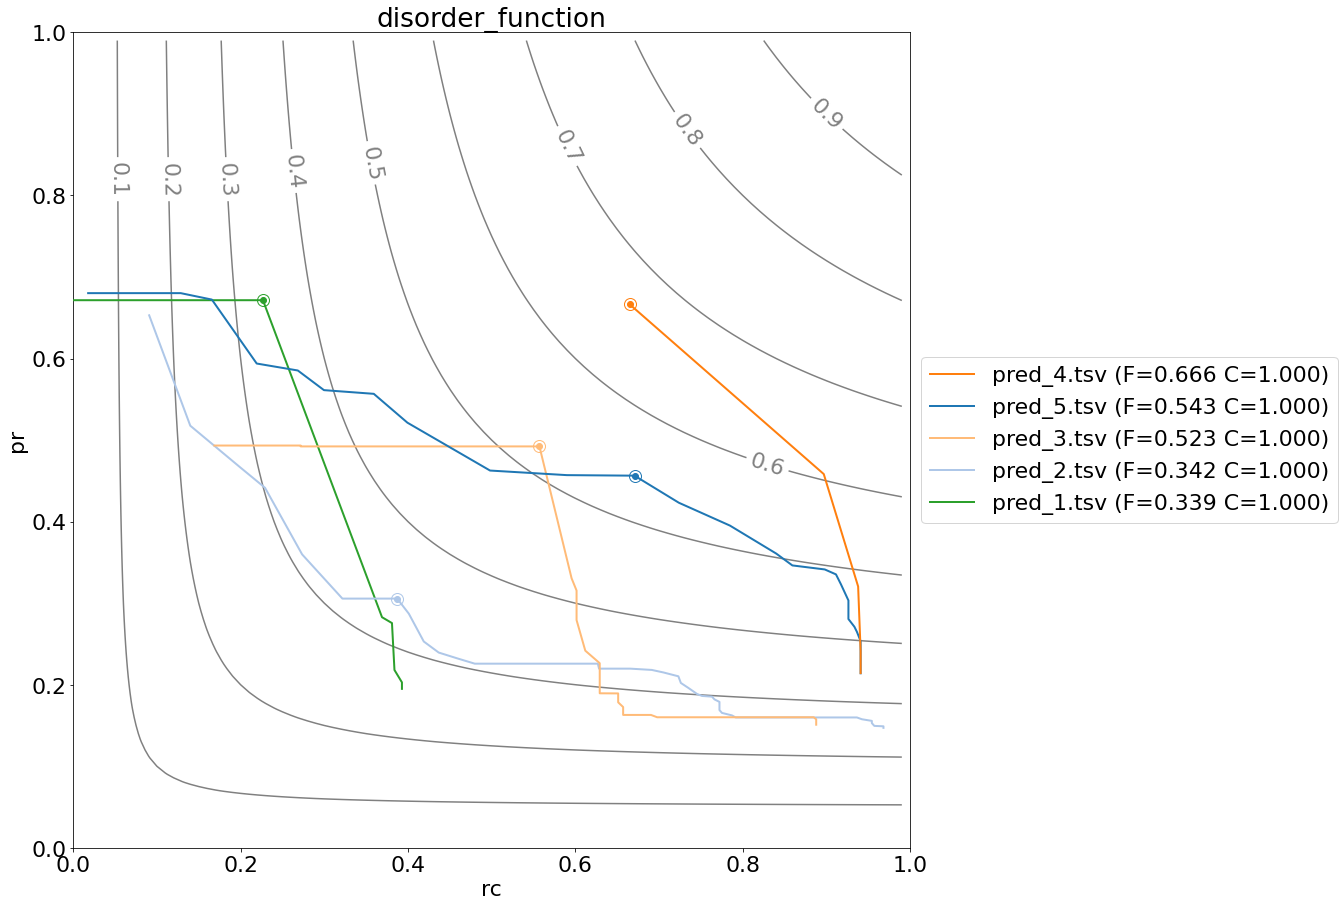

In [132]:
plt.rcParams.update({'font.size': 22})

# F-score contour lines
x = np.arange(0.01, 1, 0.01)
y = np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = 2 * X * Y / (X + Y)

for ns, df_g in df_best.groupby(level='ns'):
    fig, ax = plt.subplots(figsize=(15, 15))

     # Contour lines
    if metric in ['f', 'wf']:
        CS = ax.contour(X, Y, Z, np.arange(0.1, 1.0, 0.1), colors='gray')
        ax.clabel(CS, inline=True)#, fontsize=10)

    for i, (index, row) in enumerate(df_g.sort_values(by=[metric, 'max_cov'], ascending=[False if metric in ['f', 'wf'] else True, False]).iterrows()):
        # print(row)
        data = df_methods.loc[index[:-1]]
        ax.plot(data[cols[0]], data[cols[1]], color=row['colors'], label=row['label'], lw=2, zorder=500-i)
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=12, mfc='none', zorder=1000-i)
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=6, zorder=1000-i)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlim(0, max(1, df_best.loc[:,:,ns,:][cols[0]].max()))
    plt.ylim(0, max(1, df_best.loc[:,:,ns,:][cols[1]].max()))

    ax.set_title(ns)
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])



    plt.savefig("{}/fig_{}_{}.png".format(out_folder, metric, ns), bbox_inches='tight')
    # plt.clf()